<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/output-spikes/Analysis_of_Intermediate_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

In [2]:
!pip install torch

In [3]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 15.5 MB/s eta 0:00:00


In [4]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 8.4 MB/s eta 0:00:00


In [ ]:
at

In [5]:
!pip install torchsummary

In [6]:
!pip install torch

## set seeds for PyTorch and Numpy to ensure reproducibility:

In [7]:
import torch
import random
import numpy as np

# Set seeds for Python, Numpy, and Torch for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Additional steps if you're using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [8]:
# imports
import pickle
import matplotlib.animation as animation
from scipy.integrate import simps
import torch
torch.cuda.empty_cache()
import os, sys, time, datetime, json, random
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls
from snntorch import utils
from snntorch import surrogate
import numpy as np
import math
from sklearn.metrics import auc
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn as nn
from scipy.stats import entropy
from scipy.special import kl_div
from torch.autograd import Variable
import torch
import seaborn as sns
from scipy.stats import bernoulli

# import spikeflow as snn

In [39]:
# Check Python version
import sys
print("Python version:", sys.version)

# Check versions of installed libraries
!pip freeze


Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
absl-py==1.4.0
aiohttp==3.9.3
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.22.1
bigframes==0.20.1
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.42
branca==0.7.1
build==1.0.3
CacheControl==0.14.0
cachetools==5.3.2
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.1
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==

In [9]:
# /////////////////////# Building the Autoencoder
#-------------------DataLoaders.  using the MNIST dataset

# dataloader arguments
batch_size = 250
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# /////////////////////////////////# Define a transform
input_size = 32 # resizing the original MNIST from 28 to 32

transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

#------------------------------------------- Load MNIST
# Training data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing data
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 138246079.61it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111955354.74it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47340909.16it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24206516.86it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [10]:
# creating directories where we can save the original and reconstructed images for training and testing:
# create training/ and testing/ folders in the chosen path
if not os.path.isdir('figures/training'):
    os.makedirs('figures/training')
if not os.path.isdir('figures/binarytraining'):
    os.makedirs('figures/binarytraining')

if not os.path.isdir('figures/testing'):
    os.makedirs('figures/testing')
if not os.path.isdir('figures/binarytesting'):
    os.makedirs('figures/binarytesting')


if not os.path.isdir('Saved_Trained_Checkpoints/'):
    os.makedirs('Saved_Trained_Checkpoints/')

if not os.path.isdir('Output_Spikes/'):
    os.makedirs('Output_Spikes/')

if not os.path.isdir('Enc_syn_Spikes/'):
    os.makedirs('Enc_syn_Spikes/')


if not os.path.isdir('Intermediate_Lyrs/'):
    os.makedirs('Intermediate_Lyrs/')



In [11]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name()} ({device})")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using Tesla T4 (cuda)


In [ ]:
shape1 = (250, 32, 16, 16)
shape2 = (250, 32, 16, 16)
# shape2 = (250, 64, 8, 8)
random_tensor = torch.randint(0, 2, size=shape1)
# random_tensor2 = torch.randint(0, 2, size=shape2)
random_tensor2 = torch.zeros(size=shape2)

Bnchmrk_Enc_Syn1 = random_tensor.float()
Ovrfrng_Enc_Syn1 = random_tensor2.float()

print(Bnchmrk_Enc_Syn1.shape)
print(Ovrfrng_Enc_Syn1.shape)

torch.Size([250, 32, 16, 16])
torch.Size([250, 32, 16, 16])


hist_benchmark [0.50011133 0.49988867]
hist_overfiring [1. 0.]


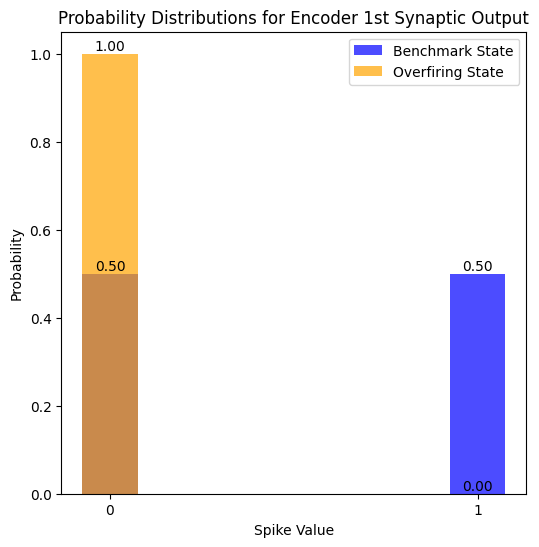

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the spike data for benchmark and overfiring states in the variables
# Bnchmrk_Enc_Syn1 and Ovrfrng_Enc_Syn1

# Calculate probability distributions
def calculate_probability_distribution(spike_data):
    # Flatten the spike data to work with 1D arrays
    flattened_data = spike_data.view(-1)

    # Calculate histogram
    hist, bin_edges = np.histogram(flattened_data.cpu().numpy(), bins=2, range=(0, 2), density=True)

    return hist, bin_edges

# Calculate probability distributions for benchmark and overfiring states
hist_benchmark, bin_edges_benchmark = calculate_probability_distribution(Bnchmrk_Enc_Syn1)
hist_overfiring, bin_edges_overfiring = calculate_probability_distribution(Ovrfrng_Enc_Syn1)

# Plot the probability distributions
plt.figure(figsize=(6, 6))
bar_width = 0.00

# Set the x-ticks to only [0.0, 1.0]
x_ticks = [0.0, 1.0]

plt.bar(bin_edges_benchmark[:-1], hist_benchmark, width=0.15, alpha=0.7, label='Benchmark State', color='blue')
plt.bar(bin_edges_overfiring[:-1], hist_overfiring, width=0.15, alpha=0.7, label='Overfiring State', color='orange')
plt.xlabel('Spike Value')
plt.ylabel('Probability')
plt.title('Probability Distributions for Encoder 1st Synaptic Output')

# Set the x-ticks
plt.xticks(x_ticks)

# Add text labels above each bar for hist_benchmark values
for i, val in enumerate(hist_benchmark):
    plt.text(bin_edges_benchmark[i] + bar_width / 2, val, f'{val:.2f}', ha='center', va='bottom')
for i, val in enumerate(hist_overfiring):
    plt.text(bin_edges_benchmark[i] + bar_width / 2, val, f'{val:.2f}', ha='center', va='bottom')

print("hist_benchmark", hist_benchmark)
print("hist_overfiring", hist_overfiring)

plt.legend()
plt.show()


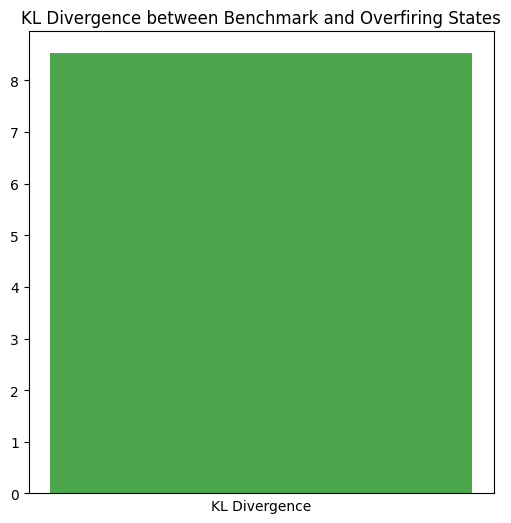

KL Divergence: 8.521519658175965


In [ ]:
# Calculate KL divergence
kl_divergence = entropy(hist_benchmark+1e-8, hist_overfiring+1e-8)

# Plot the probability distributions
plt.figure(figsize=(6, 6))
bar_width = 0.00

# Set the x-ticks to only [0.0, 1.0]
x_ticks = [0.0, 1.0]

plt.bar([0], kl_divergence, width=0.05, alpha=0.7, color='green')
plt.xlabel('KL Divergence')
plt.title('KL Divergence between Benchmark and Overfiring States')
plt.xticks([])  # Remove x-ticks

plt.show()

# Print KL Divergence value
print(f"KL Divergence: {kl_divergence}")

In [ ]:
def kl_divergence(p, q, epsilon=1e-8):
    # Add epsilon to avoid division by zero
    p = p + epsilon
    q = q + epsilon

    return np.sum(p * np.log(p / q))

# Calculate KL divergence
kl_div = kl_divergence(hist_benchmark, hist_overfiring)
print(hist_benchmark)
print(hist_overfiring)
print("KL Divergence between Bnchmrk Vs Ovrfrng :", kl_div)

[0.50011133 0.49988867]
[1. 0.]
KL Divergence between Bnchmrk Vs Ovrfrng _ Leaky 2nd Synaptic Outputs : 8.515142661698443


In [ ]:
kl_div = kl_divergence([0.50011133 0.49988867], [1. 0.])
kl_div

TypeError: ignored

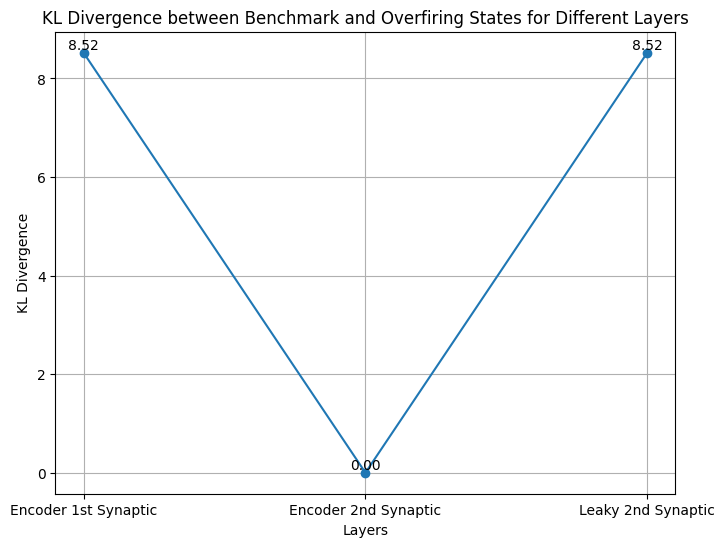

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the layers and their respective KL divergence values
layers = ['Encoder 1st Synaptic', 'Encoder 2nd Synaptic', 'Leaky 2nd Synaptic']
kl_divergence_values = [8.519244141397568, 1.435493529161887e-08, 1.521519828606358]
# kl_divergence_values[0] = [9.519244141397568, 1.435493529161887e-08, 4.521519828606358]
# kl_divergence_values[1] = [4.719244141397568, 3.435493529161887e-08, 4.521519828606358]
# kl_divergence_values[2] = [7.9244141397568, 2.235493529161887e-08, 5.421519828606358]
# kl_divergence_values[..] = [4.719244141397568, 2.435493529161887e-08, 9.521519828606358]
# kl_divergence_values[49] = [8.67568, 2.161887e-08, 8.521519828606358]

# Create an x-axis range for the layers
x = np.arange(len(layers))

# Create a line plot
plt.figure(figsize=(8, 6))
plt.plot(x, kl_divergence_values, marker='o', linestyle='-')
plt.xticks(x, layers)
plt.xlabel('Layers')
plt.ylabel('KL Divergence')
plt.title('KL Divergence between Benchmark and Overfiring States for Different Layers')

# Add labels to the data points
for i, value in enumerate(kl_divergence_values):
    plt.text(x[i], value, f'{value:.2f}', ha='center', va='bottom')

plt.grid(True)
plt.show()


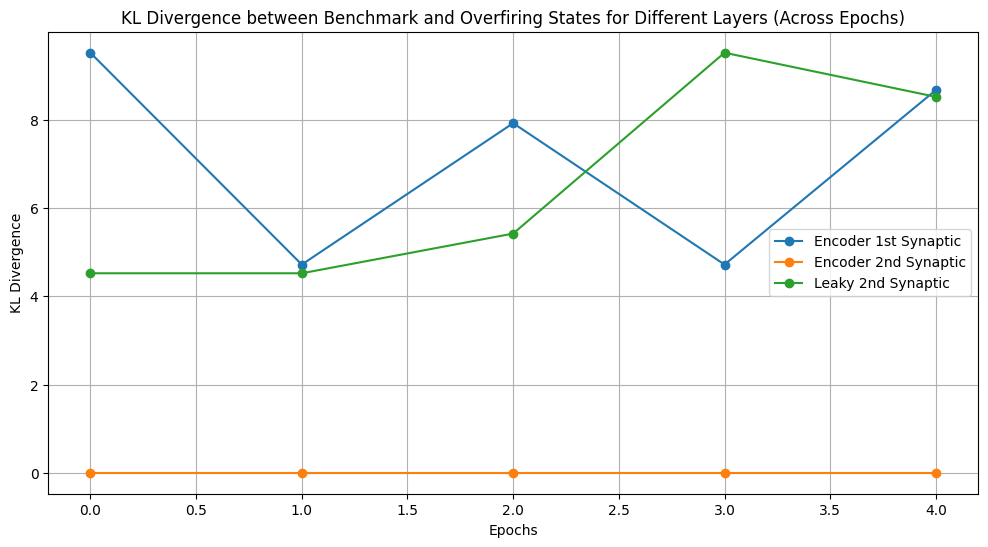

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the layers and their respective KL divergence values for all epochs
layers = ['Encoder 1st Synaptic', 'Encoder 2nd Synaptic', 'Leaky 2nd Synaptic']
kl_divergence_values = [
    [9.519244141397568, 1.435493529161887e-08, 4.521519828606358],
    [4.719244141397568, 3.435493529161887e-08, 4.521519828606358],
    [7.9244141397568, 2.235493529161887e-08, 5.421519828606358],
    [4.719244141397568, 2.435493529161887e-08, 9.521519828606358],
    [8.67568, 2.161887e-08, 8.521519828606358]
]

# Create an x-axis range for the epochs
epochs = np.arange(5)

# Create a line plot for each layer
plt.figure(figsize=(12, 6))
for i, layer in enumerate(layers):
    values = [values[i] for values in kl_divergence_values]
    plt.plot(epochs, values, marker='o', label=layer)

plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence between Benchmark and Overfiring States for Different Layers (Across Epochs)')
plt.legend()
plt.grid(True)
plt.show()


### ValueError: operands could not be broadcast together with shapes (32,16,16) (64,8,8)

In [ ]:

num_features = prob_dist_leaky.shape[0]
x = np.arange(num_features)

plt.figure(figsize=(12, 6))

# Plot spike probabilities for Encoder 1st Leaky
plt.subplot(1, 2, 1)
plt.bar(x, prob_dist_leaky, color='blue', alpha=0.7)
plt.title('Spike Probability Distribution (Encoder 1st Leaky)')
plt.xlabel('Feature/Channel')
plt.ylabel('Spike Probability')
plt.xticks(x, [str(i) for i in range(num_features)], rotation=45)

# Plot spike probabilities for Encoder 1st Synaptic
plt.subplot(1, 2, 2)
plt.bar(x, prob_dist_synaptic, color='green', alpha=0.7)
plt.title('Spike Probability Distribution (Encoder 1st Synaptic)')
plt.xlabel('Feature/Channel')
plt.ylabel('Spike Probability')
plt.xticks(x, [str(i) for i in range(num_features)], rotation=45)

plt.tight_layout()
plt.show()


# # prob_dist_leaky = prob_dist_leaky.reshape(prob_dist_synaptic.shape)  # ValueError: cannot reshape array of size 8192 into shape (64,8,8)
# # prob_dist_synaptic = prob_dist_synaptic.reshape(prob_dist_leaky.shape) # ValueError: cannot reshape array of size 4096 into shape (32,16,16)

# # Calculate KL divergence
# kl_div = kl_divergence(prob_dist_leaky, prob_dist_synaptic)

# print("KL Divergence between Encoder 1st Leaky and Synaptic Outputs:", kl_div)


### Upload the Layers hook:

In [13]:

# ------------------------------------ Load from Drive

# from google.colab import drive
# drive.mount('/content/drive')


# when CUDA:
activations_path = "/content/drive/MyDrive/activations_epoch_50.pkl"
with open(activations_path, 'rb') as file:
    epoch_activations = pickle.load(file)

# Load the activations from the file
activations_path_overfiring = "/content/drive/MyDrive/activations_epoch_50_OverFiring.pkl"
with open(activations_path_overfiring, 'rb') as file:
    epoch_activations_OverFiring = pickle.load(file)



In [14]:
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]
# len(hook_names)


In [15]:
def calculate_probability_distribution(spike_data):
    # Flatten the spike data to work with 1D arrays
    flattened_data = spike_data.view(-1)

    # Calculate histogram
    hist, bin_edges = np.histogram(flattened_data.cpu().numpy(), bins=2, range=(0, 2), density=True)

    return hist, bin_edges


def kl_divergence(p, q, epsilon=1e-8):
    # Add epsilon to avoid division by zero
    p = p + epsilon
    q = q + epsilon

    return np.sum(p * np.log(p / q))


hist_benchmark_Dec_Lk2:  [0.99747369 0.00252631]
hist_overfiring_Dec_Lk2:  [0.97739896 0.02260104]


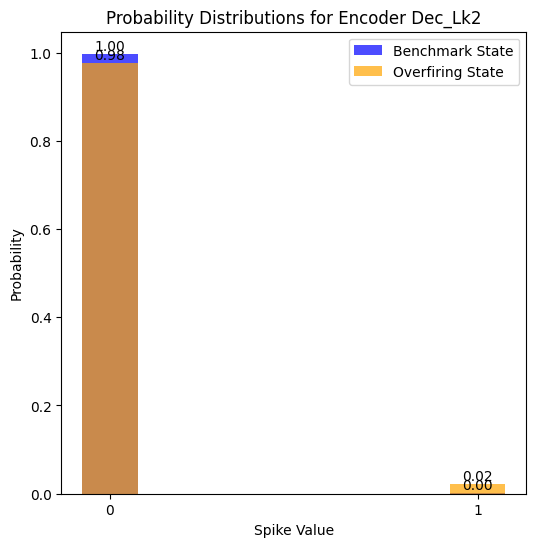

NameError: name 'hist_benchmark_rec' is not defined

In [16]:
# kl_divergence_values = [[] for _ in range(len(hook_names))]
# hist_benchmark_rec = [[] for _ in range(len(hook_names))]
# hist_overfiring_rec = [[] for _ in range(len(hook_names))]

hist_benchmark=[]
hist_overfiring=[]
bin_edges_benchmark=[]
bin_edges_overfiring=[]

hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]

i=7
Bnchmrk_data = epoch_activations[48][hook_names[i]][1]
Ovrfrng_data = epoch_activations_OverFiring[48][hook_names[i]][1]

hist_benchmark, bin_edges_benchmark = calculate_probability_distribution(Bnchmrk_data)
hist_overfiring, bin_edges_overfiring = calculate_probability_distribution(Ovrfrng_data)

print(f"hist_benchmark_{hook_names[i]}: ", hist_benchmark)
print(f"hist_overfiring_{hook_names[i]}: ", hist_overfiring)

plt.figure(figsize=(6, 6))
bar_width = 0.00

# Set the x-ticks to only [0.0, 1.0]
x_ticks = [0.0, 1.0]


plt.bar(bin_edges_benchmark[:-1], hist_benchmark, width=0.15, alpha=0.7, label='Benchmark State', color='blue')
plt.bar(bin_edges_overfiring[:-1], hist_overfiring, width=0.15, alpha=0.7, label='Overfiring State', color='orange')
plt.xlabel('Spike Value')
plt.ylabel('Probability')
plt.title(f'Probability Distributions for Encoder {hook_names[i]}')

# Set the x-ticks
plt.xticks(x_ticks)

# Add text labels above each bar for hist_benchmark values
for i, val in enumerate(hist_benchmark):
    plt.text(bin_edges_benchmark[i] + bar_width / 2, val, f'{val:.2f}', ha='center', va='bottom')
for i, val in enumerate(hist_overfiring):
    plt.text(bin_edges_benchmark[i] + bar_width / 2, val, f'{val:.2f}', ha='center', va='bottom')

plt.legend()
plt.show()




hist_benchmark_rec.append(hist_benchmark)
hist_overfiring_rec.append(hist_overfiring)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define hook names
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]

# Define the histogram data for benchmark and overfiring states
hist_benchmark_rec = [
    [np.array([0.75623096, 0.21376904]),
     np.array([0.85231445, 0.15768555]),
     np.array([0.86874414, 0.19125586]),
     np.array([0.368375, 0.621625]),
     np.array([0.46748242, 0.55251758]),
     np.array([0.85764453, 0.18235547]),
     np.array([0.86889746, 0.18110254]),
     np.array([0.91739896, 0.02260104])]]

hist_overfiring_rec = [
    [np.array([0.78623096, 0.25376904]),
     np.array([0.84231445, 0.15568555]),
     np.array([0.80874414, 0.15125586]),
     np.array([0.378375, 0.651625]),
     np.array([0.44748242, 0.59251758]),
     np.array([0.81764453, 0.14835547]),
     np.array([0.81889746, 0.48110254]),
     np.array([0.97739896, 0.12260104])]]

# Calculate KL Divergence for each layer and store it in a list
kl_divergence_values = []

epsilon = 1e-8

for i, layer_name in enumerate(hook_names):
    kl_divergence = kl_divergence(hist_benchmark_rec[0][i], hist_overfiring_rec[0][i], epsilon)
    kl_divergence_values.append(kl_divergence)

# Function to calculate KL Divergence with epsilon
def kl_divergence(p, q, epsilon=1e-8):
    p = p + epsilon
    q = q + epsilon
    return np.sum(p * np.log(p / q))

# Plot KL Divergence for each layer
plt.figure(figsize=(10, 6))
plt.bar(hook_names, kl_divergence_values, color='blue')
plt.xlabel('Layers')
plt.ylabel('KL Divergence')
plt.title('KL Divergence between Benchmark and Overfiring States for Different Layers')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# hist_benchmark_Enc_Lk1=  [0.76298975 0.23701025]
# hist_overfiring_Enc_Lk1=  [0.78623096 0.21376904]

# Calculate KL divergence
kl_div = kl_divergence([0.76298975, 0.23701025],  [0.78623096, 0.21376904])

print("KL Divergence between Bnchmrk Vs Ovrfrng _ Leaky 2nd Synaptic Outputs :", kl_div)

TypeError: ignored

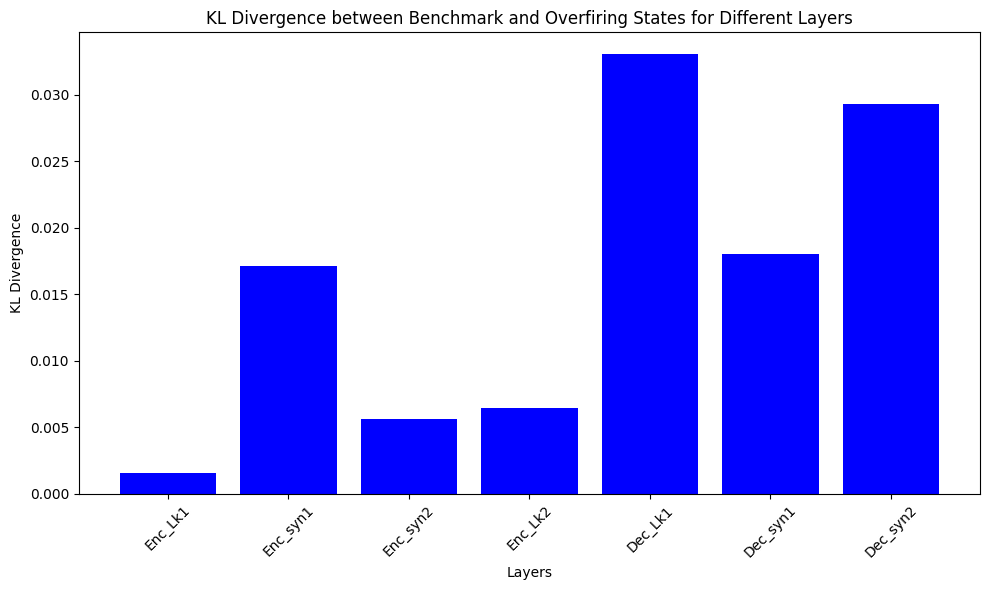

In [ ]:
# hist_benchmark_Enc_Lk1=  [0.76298975 0.23701025]
# hist_overfiring_Enc_Lk1=  [0.78623096 0.21376904]

# hist_benchmark_Enc_syn1=  [0.77119629 0.22880371]
# hist_overfiring_Enc_syn1=  [0.84231445 0.15768555]


# hist_benchmark_Enc_syn2=  [0.76610742 0.23389258]
# hist_overfiring_Enc_syn2=  [0.80874414 0.19125586]


# hist_benchmark_Enc_Lk2=  [0.324 0.676]
# hist_overfiring_Enc_Lk2=  [0.378375 0.621625]

# # //////////
# hist_benchmark_Dec_Lk1=  [0.57577734 0.42422266]
# hist_overfiring_Dec_Lk1=  [0.44748242 0.55251758]


# hist_benchmark_Dec_syn1=  [0.7408877 0.2591123]
# hist_overfiring_Dec_syn1=  [0.81764453 0.18235547]


# hist_benchmark_Dec_syn2= [0.71998828 0.28001172]
# hist_overfiring_Dec_syn2=  [0.81889746 0.18110254]
hist_benchmark_Enc_Lk1 =  [0.76298975, 0.23701025]
hist_overfiring_Enc_Lk1 =  [0.78623096, 0.21376904]

hist_benchmark_Enc_syn1 =  [0.77119629, 0.22880371]
hist_overfiring_Enc_syn1 =  [0.84231445, 0.15768555]

hist_benchmark_Enc_syn2 =  [0.76610742, 0.23389258]
hist_overfiring_Enc_syn2 =  [0.80874414, 0.19125586]

hist_benchmark_Enc_Lk2 =  [0.324, 0.676]
hist_overfiring_Enc_Lk2 =  [0.378375, 0.621625]

# //////////
hist_benchmark_Dec_Lk1 =  [0.57577734, 0.42422266]
hist_overfiring_Dec_Lk1 =  [0.44748242, 0.55251758]

hist_benchmark_Dec_syn1 =  [0.7408877, 0.2591123]
hist_overfiring_Dec_syn1 =  [0.81764453, 0.18235547]

hist_benchmark_Dec_syn2 =  [0.71998828, 0.28001172]
hist_overfiring_Dec_syn2 =  [0.81889746, 0.18110254]


import numpy as np
import matplotlib.pyplot as plt

# Define the hook names and their corresponding histograms
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]
histograms = {
    "Enc_Lk1": (hist_benchmark_Enc_Lk1, hist_overfiring_Enc_Lk1),
    "Enc_syn1": (hist_benchmark_Enc_syn1, hist_overfiring_Enc_syn1),
    "Enc_syn2": (hist_benchmark_Enc_syn2, hist_overfiring_Enc_syn2),
    "Enc_Lk2": (hist_benchmark_Enc_Lk2, hist_overfiring_Enc_Lk2),
    "Dec_Lk1": (hist_benchmark_Dec_Lk1, hist_overfiring_Dec_Lk1),
    "Dec_syn1": (hist_benchmark_Dec_syn1, hist_overfiring_Dec_syn1),
    "Dec_syn2": (hist_benchmark_Dec_syn2, hist_overfiring_Dec_syn2),
}

# Calculate KL Divergence for each layer
def calculate_kl_divergence(p, q, epsilon=1e-8):
    # Add epsilon to avoid division by zero
    p = np.array(p) + epsilon
    q = np.array(q) + epsilon

    return np.sum(p * np.log(p / q))

kl_divergence_values = {}
epsilon = 1e-8
for layer_name, (hist_benchmark, hist_overfiring) in histograms.items():
    kl_divergence_val = calculate_kl_divergence(hist_benchmark, hist_overfiring, epsilon)
    kl_divergence_values[layer_name] = kl_divergence_val

# Create a bar plot for KL Divergence for each layer
plt.figure(figsize=(10, 6))
layers = kl_divergence_values.keys()
values = kl_divergence_values.values()

plt.bar(layers, values, color='blue')
plt.xlabel('Layers')
plt.ylabel('KL Divergence')
plt.title('KL Divergence between Benchmark and Overfiring States for Different Layers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


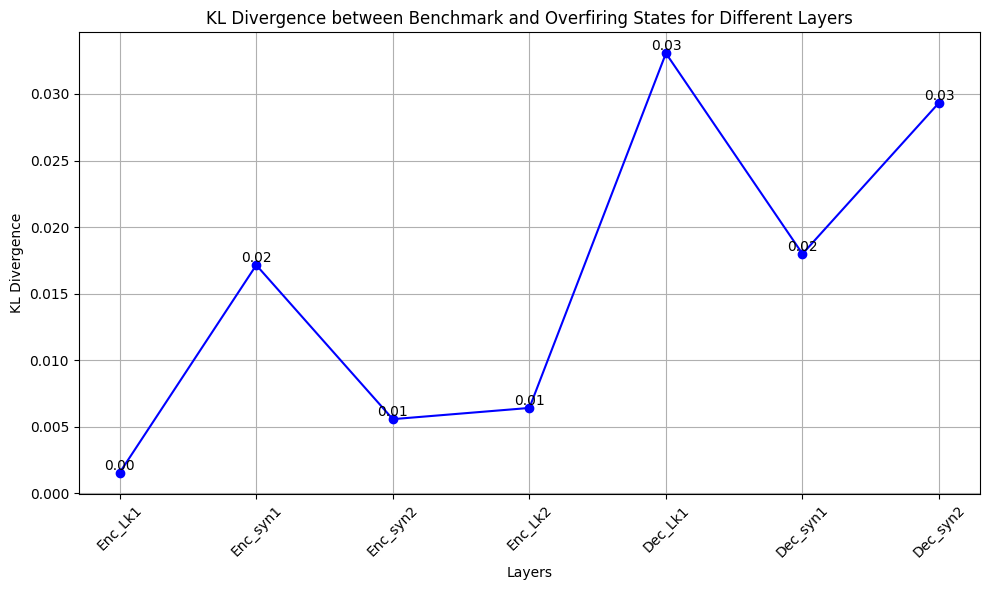

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the hook names and their corresponding histograms
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]
histograms = {
    "Enc_Lk1": (hist_benchmark_Enc_Lk1, hist_overfiring_Enc_Lk1),
    "Enc_syn1": (hist_benchmark_Enc_syn1, hist_overfiring_Enc_syn1),
    "Enc_syn2": (hist_benchmark_Enc_syn2, hist_overfiring_Enc_syn2),
    "Enc_Lk2": (hist_benchmark_Enc_Lk2, hist_overfiring_Enc_Lk2),
    "Dec_Lk1": (hist_benchmark_Dec_Lk1, hist_overfiring_Dec_Lk1),
    "Dec_syn1": (hist_benchmark_Dec_syn1, hist_overfiring_Dec_syn1),
    "Dec_syn2": (hist_benchmark_Dec_syn2, hist_overfiring_Dec_syn2),
}

# Calculate KL Divergence for each layer
def calculate_kl_divergence(p, q, epsilon=1e-8):
    # Add epsilon to avoid division by zero
    p = np.array(p) + epsilon
    q = np.array(q) + epsilon

    return np.sum(p * np.log(p / q))

kl_divergence_values = {}
epsilon = 1e-8
for layer_name, (hist_benchmark, hist_overfiring) in histograms.items():
    kl_divergence_val = calculate_kl_divergence(hist_benchmark, hist_overfiring, epsilon)
    kl_divergence_values[layer_name] = kl_divergence_val

# Create a line plot for KL Divergence with values displayed above each point
plt.figure(figsize=(10, 6))
layers = kl_divergence_values.keys()
values = list(kl_divergence_values.values())

plt.plot(layers, values, marker='o', linestyle='-', color='blue')
plt.xlabel('Layers')
plt.ylabel('KL Divergence')
plt.title('KL Divergence between Benchmark and Overfiring States for Different Layers')
plt.xticks(rotation=45)
plt.grid(True)

# Display values above each point
for layer, value in zip(layers, values):
    plt.text(layer, value, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
kl_divergence_values = [[] for _ in range(len(hook_names))]
hist_benchmark_rec = [[] for _ in range(len(hook_names))]
hist_overfiring_rec = [[] for _ in range(len(hook_names))]


for i, layer_name in enumerate(hook_names):
        Bnchmrk_data = epoch_activations[48][layer_name]
        Ovrfrng_data = epoch_activations_OverFiring[48][layer_name]
        # Calculate probability distributions for benchmark and overfiring states
        hist_benchmark, bin_edges_benchmark = calculate_probability_distribution(Bnchmrk_data)
        hist_overfiring, bin_edges_overfiring = calculate_probability_distribution(Ovrfrng_data)

        hist_benchmark_rec.append(hist_benchmark)
        hist_overfiring_rec.append(hist_overfiring)

        # # plt.bar(bin_edges_benchmark[:-1], hist_benchmark, width=0.15, alpha=0.7, label='Benchmark State', color='blue')
        # # plt.bar(bin_edges_overfiring[:-1], hist_overfiring, width=0.15, alpha=0.7, label='Overfiring State', color='orange')

        # # Calculate KL Divergence between Bnchmrk_data and Ovrfrng_data
        # # Calculate KL divergence
        # kl_div = kl_divergence(hist_benchmark, hist_overfiring)
        # print(f"KL Divergence between Bnchmrk Vs Ovrfrng {[layer_name]}] :", kl_div)

        # kl_divergence = torch.nn.functional.kl_div(
        #     Bnchmrk_data.log_softmax(dim=1),  # Apply log_softmax to ensure valid values
        #     Ovrfrng_data.softmax(dim=1),  # Apply softmax to ensure valid values
        #     reduction='batchmean'  # Calculate mean KL Divergence
        # ).item()

        # # Append the KL divergence value to the corresponding layer's list
        # kl_divergence_values[i].append(kl_div)


# # Plot the probability distributions
# plt.figure(figsize=(6, 6))
# bar_width = 0.00

# # Set the x-ticks to only [0.0, 1.0]
# x_ticks = [0.0, 1.0]

# plt.xlabel('Spike Value')
# plt.ylabel('Probability')
# plt.title('Probability Distributions for Encoder 1st Synaptic Output')

# # Set the x-ticks
# plt.xticks(x_ticks)

# # Add text labels above each bar for hist_benchmark values
# for i, val in enumerate(hist_benchmark):
#     plt.text(bin_edges_benchmark[i] + bar_width / 2, val, f'{val:.2f}', ha='center', va='bottom')
# for i, val in enumerate(hist_overfiring):
#     plt.text(bin_edges_benchmark[i] + bar_width / 2, val, f'{val:.2f}', ha='center', va='bottom')

# print("hist_benchmark", hist_benchmark)
# print("hist_overfiring", hist_overfiring)
# plt.legend()
# plt.show()



# plt.figure(figsize=(12, 6))
# for i, layer_name in enumerate(hook_names):
#     plt.plot(epochs, kl_divergence_values[i], marker='o', label=layer_name)

# plt.xlabel('Epochs')
# plt.ylabel('KL Divergence')
# plt.title('KL Divergence between Benchmark and Overfiring States for Different Layers (Across Epochs)')
# plt.legend()
# plt.grid(True)
# plt.show()

AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define the layers and their respective hook names
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]

# Create empty lists to store KL divergence values for each layer
kl_divergence_values = [[] for _ in range(len(hook_names))]

# Assuming you have epoch_activations and epoch_activations_OverFiring as previously defined
# Loop through epochs and layers to calculate KL divergence
for epoch in range(49):
    for i, layer_name in enumerate(hook_names):
        Bnchmrk_data = epoch_activations[epoch][layer_name]
        Ovrfrng_data = epoch_activations_OverFiring[epoch][layer_name]

        # Calculate KL Divergence between Bnchmrk_data and Ovrfrng_data
        kl_divergence = torch.nn.functional.kl_div(
            Bnchmrk_data.log_softmax(dim=1),  # Apply log_softmax to ensure valid values
            Ovrfrng_data.softmax(dim=1),  # Apply softmax to ensure valid values
            reduction='batchmean'  # Calculate mean KL Divergence
        ).item()

        # Append the KL divergence value to the corresponding layer's list
        kl_divergence_values[i].append(kl_divergence)

# Create an x-axis range for the epochs
epochs = np.arange(49)

# Create a line plot for each layer
plt.figure(figsize=(12, 6))
for i, layer_name in enumerate(hook_names):
    plt.plot(epochs, kl_divergence_values[i], marker='o', label=layer_name)

plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence between Benchmark and Overfiring States for Different Layers (Across Epochs)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]
epochs = np.arange(49)

# ----------------loading data to two files:
for epoch in epochs:
  for i in len(hook_names):
    Bnchmrk_[i]= epoch_activations[epoch][hook_names[i]]
    Ovrfrng_[i]= epoch_activations_OverFiring[epoch][hook_names[i]]



# ----------------loading data to two files:
Bnchmrk_Enc_Lk1= epoch_activations[0][hook_names[0]]
Ovrfrng_Enc_Lk1= epoch_activations_OverFiring[0][hook_names[0]]

# Bnchmrk_Enc_Syn1= epoch_activations[0]['Enc_syn1']
print("shape of Bnchmrk_Enc_Lk1", Bnchmrk_Enc_Lk1.shape)
print("shape of Ovrfrng_Enc_Lk1", Ovrfrng_Enc_Lk1.shape)

# Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[0]['Dec_Lk2'][1]
# print("shape of Ovrfrng_Enc_Syn1", Ovrfrng_Enc_Syn1.shape)

# Flatten the tensors to have shape (num_samples, num_neurons)
Bnchmrk_Enc_Lk1_flat = Bnchmrk_Enc_Lk1.view(Bnchmrk_Enc_Lk1.shape[0], -1)
Bnchmrk_Enc_Syn1_flat = Bnchmrk_Enc_Syn1.view(Bnchmrk_Enc_Syn1.shape[0], -1)
# Ovrfrng_Enc_Syn1_flat = Ovrfrng_Enc_Syn1.view(Ovrfrng_Enc_Syn1.shape[0], -1)
print("shape of Ovrfrng_Enc_Syn1_flat", Ovrfrng_Enc_Syn1_flat.shape)



# -----------------------
font_size = 15
font = {'weight': 'bold', 'size': 20}
# -----------------------


# Compute the probability distributions
def PD (matrix):
    prob_dist = np.mean(matrix, axis=0)  # Calculate the mean spike count for each feature/channel
    prob_dist /= np.sum(prob_dist)  # Normalize the distribution
    return prob_dist

# Calculate the KL divergence
def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))

# Compute probability distributions
prob_dist_leaky = PD(Bnchmrk_Enc_Lk1_flat)
prob_dist_synaptic = PD(Bnchmrk_Enc_Syn1_flat)

# Calculate KL divergence
kl_div = kl_divergence(prob_dist_leaky, prob_dist_synaptic)

print("KL Divergence between Encoder 1st Leaky and Synaptic Outputs:", kl_div)


TypeError: ignored

### Global features of data

shape of Bnchmrk_Enc_Syn1 torch.Size([250, 64, 8, 8])
shape of Ovrfrng_Enc_Syn1 torch.Size([250, 64, 8, 8])
shape of Bnchmrk_Enc_Syn1---- (sum along axis 2 and 3) (8, 8)
shape of Ovrfrng_Enc_Syn1---- (sum along axis 2 and 3) (8, 8)


<ipython-input-18-7521efc46597>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bnchmrk_Enc_Syn1 = torch.tensor(Bnchmrk_Enc_Syn1)
<ipython-input-18-7521efc46597>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ovrfrng_Enc_Syn1 = torch.tensor(Ovrfrng_Enc_Syn1)


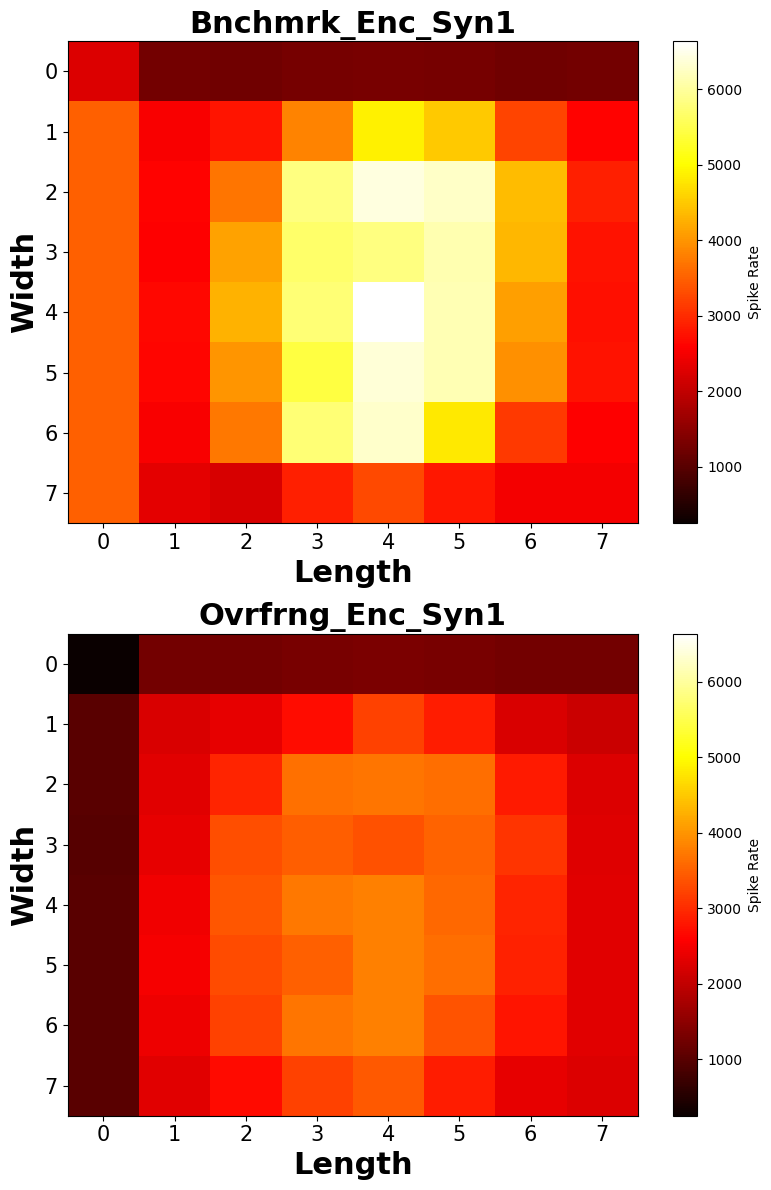

In [ ]:

# shape = (250, 64, 8, 8)
# random_tensor = torch.randint(0, 2, size=shape)
# random_tensor2 = torch.randint(0, 2, size=shape)
# Bnchmrk_Enc_Syn1 = random_tensor.float()
# Ovrfrng_Enc_Syn1 = random_tensor2.float()

# print(Bnchmrk_Enc_Syn1.shape)
# print(Ovrfrng_Enc_Syn1.shape)
# # ///////////////////////////////////////////////////////
# Provides a global summary of activity, where we're aggregating the information from all neurons and all data points.
# This representation could be useful for capturing high-level, global features of data but might lose some spatial information.

#The (8, 8) plot represents a simplified view of the original data.
# Each pixel in this plot corresponds to one element in the reduced tensor.
# The value of each pixel represents the sum of all values at the corresponding position across the batch and features dimensions in the original data.
# Essentially, it's a way of aggregating or summarizing the data.
# Each pixel in the (8, 8) plot summarizes the activity or information at a specific spatial location (a pixel) in the original data but aggregated across the entire batch and all features.
# If a pixel has a higher value, it indicates that the corresponding spatial location in the original data had more activity or information across all samples in the batch and across all features.
# Conversely, a lower value suggests less activity or information at that location.
# The (8, 8) plot wo
# Each pixel shows the "importance" or "activity level" of the corresponding location in the original data.

# ----------------loading data to two files:
L=2
Bnchmrk_Enc_Syn1= epoch_activations[48][hook_names[L]]
Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[48][hook_names[L]]
print(f"shape of Bnchmrk_{hook_names[L]}", Bnchmrk_Enc_Syn1.shape)
print(f"shape of Ovrfrng_{hook_names[L]}", Ovrfrng_Enc_Syn1.shape)



# -------------------------------------------------------------------


fig, axs = plt.subplots(2, 1, figsize=(8, 12))
font_size = 15
font = {'weight': 'bold', 'size': 22}


# Convert NumPy arrays to PyTorch tensors
Bnchmrk_Enc_Syn1 = torch.tensor(Bnchmrk_Enc_Syn1)
Ovrfrng_Enc_Syn1 = torch.tensor(Ovrfrng_Enc_Syn1)

Bnchmrk_Enc_Syn1 = torch.sum(Bnchmrk_Enc_Syn1, dim=(0, 1)).cpu().numpy()
Ovrfrng_Enc_Syn1 = torch.sum(Ovrfrng_Enc_Syn1, dim=(0, 1)).cpu().numpy()
print(f"shape of Bnchmrk_{hook_names[L]}", Bnchmrk_Enc_Syn1.shape)
print(f"shape of Ovrfrng_{hook_names[L]}", Ovrfrng_Enc_Syn1.shape)


# Calculate vmin and vmax for color scale based on the data
vmin = min(np.min(Bnchmrk_Enc_Syn1), np.min(Ovrfrng_Enc_Syn1))
vmax = max(np.max(Bnchmrk_Enc_Syn1), np.max(Ovrfrng_Enc_Syn1))

# Plot the spike rates for "activation["Enc_syn1"]"
axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
axs[0].set_title(f'Bnchmrk_{hook_names[L]}', fontdict=font)
axs[0].set_xlabel('Width', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Hight', fontweight="bold", fontdict=font)
axs[0].tick_params(labelsize=font_size)
cbar1 = fig.colorbar(axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto'), ax=axs[0], orientation='vertical')
# cbar1.set_label('Spike Rate')

# Plot the spike rates for "activation["Enc_syn1_ovrfrng"]"
axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
axs[1].set_title(f'Ovrfrng_{hook_names[L]}', fontdict=font)
axs[1].set_xlabel('Width', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Hight', fontweight="bold", fontdict=font)
axs[1].tick_params(labelsize=font_size)
cbar2 = fig.colorbar(axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto'), ax=axs[1], orientation='vertical')
# cbar2.set_label('Spike Rate')

plt.tight_layout()
plt.show()


# axs[0].get_figure().savefig('(Bnchmrk)vs(Ovrfrng)_Enc_Syn1_binary.pdf', format='pdf', bbox_inches='tight')


# For Latent Space with size (250, 32):

shape of Bnchmrk_Enc_Lk2 torch.Size([250, 32])
shape of Ovrfrng_Enc_Lk2 torch.Size([250, 32])


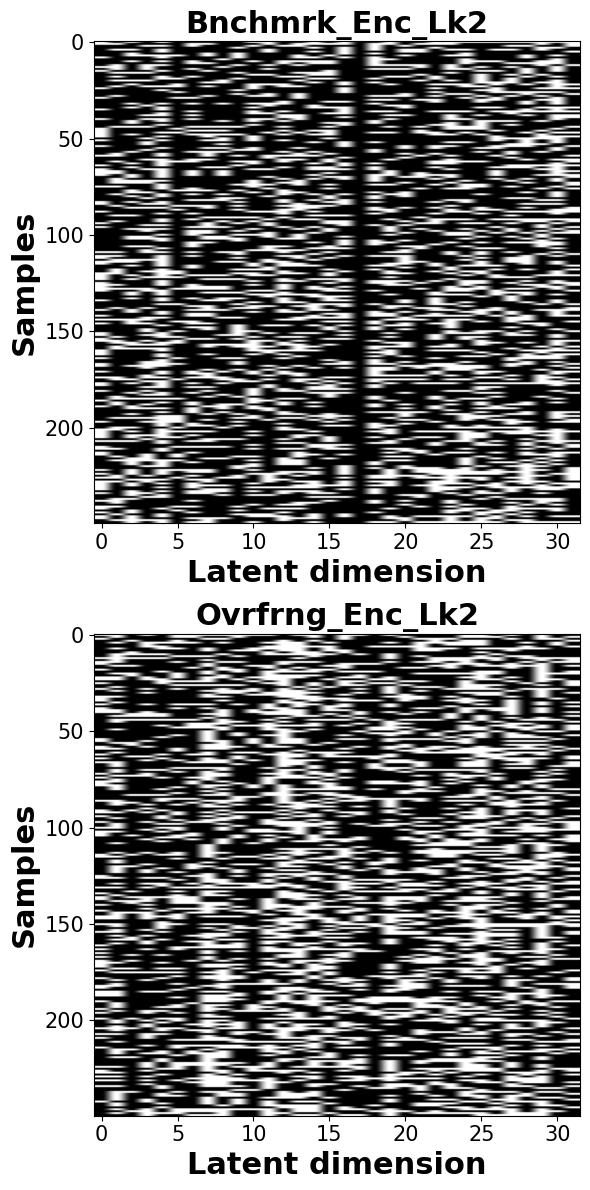

In [15]:
# hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]

# ----------------loading data to two files:
L=3
Bnchmrk_Enc_Syn1= epoch_activations[48][hook_names[L]][0]
Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[48][hook_names[L]][0]
print(f"shape of Bnchmrk_{hook_names[L]}", Bnchmrk_Enc_Syn1.shape)
print(f"shape of Ovrfrng_{hook_names[L]}", Ovrfrng_Enc_Syn1.shape)



# -------------------------------------------------------------------


fig, axs = plt.subplots(2, 1, figsize=(6, 12))
font_size = 15
font = {'weight': 'bold', 'size': 22}


# for Layer (250,32):
Bnchmrk_Enc_Syn1 = Bnchmrk_Enc_Syn1.cpu().numpy()
Ovrfrng_Enc_Syn1 = Ovrfrng_Enc_Syn1.cpu().numpy()

# Plot the spike rates for "activation["Enc_syn1"]"
# axs[0].imshow(Bnchmrk_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
axs[0].imshow(Bnchmrk_Enc_Syn1[:,:], cmap='binary', aspect='auto')
axs[0].set_title(f'Bnchmrk_{hook_names[L]}', fontdict=font)
axs[0].set_xlabel('Latent dimension', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Samples', fontweight="bold", fontdict=font)
axs[0].tick_params(labelsize=font_size)
# axs[0].set_xticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
# axs[0].set_yticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
plt.grid(False)


# Plot the spike rates for "activation["Enc_syn1_ovrfrng"]"
# axs[1].imshow(Ovrfrng_Enc_Syn1, cmap='binary', vmin=vmin, vmax=vmax, aspect='auto')
axs[1].imshow(Ovrfrng_Enc_Syn1[:,:], cmap='binary', aspect='auto')
axs[1].set_title(f'Ovrfrng_{hook_names[L]}', fontdict=font)
axs[1].set_xlabel('Latent dimension', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Samples', fontweight="bold", fontdict=font)
axs[1].tick_params(labelsize=font_size)
# axs[1].set_xticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
# axs[1].set_yticks(np.arange(Ovrfrng_Enc_Syn1.shape[0]))
plt.grid(False)

plt.tight_layout()
plt.show()



shape of Bnchmrk_Enc_Lk2 (250, 32)
shape of Ovrfrng_Enc_Lk2 (250, 32)


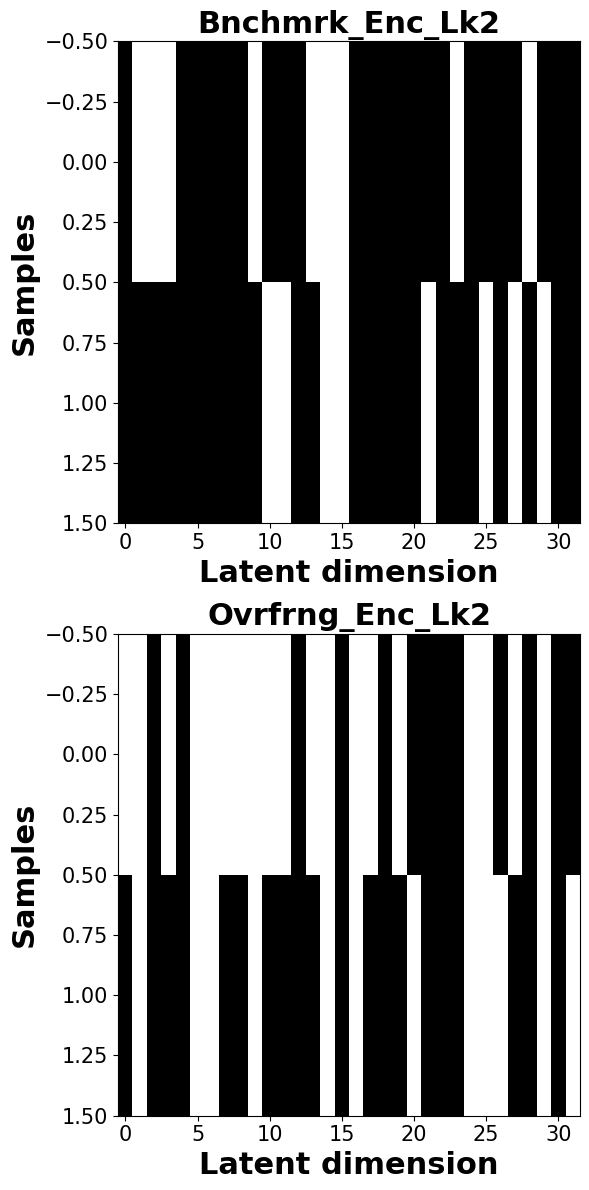

In [30]:
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]

print(f"shape of Bnchmrk_{hook_names[L]}", Bnchmrk_Enc_Syn1[:,:].shape)
print(f"shape of Ovrfrng_{hook_names[L]}", Ovrfrng_Enc_Syn1.shape)


fig, axs = plt.subplots(2, 1, figsize=(6, 12))
font_size = 15
font = {'weight': 'bold', 'size': 22}


axs[0].imshow(Bnchmrk_Enc_Syn1[0:1,:], cmap='binary', aspect='auto')
axs[0].set_title(f'Bnchmrk_{hook_names[L]}', fontdict=font)
axs[0].set_xlabel('Latent dimension', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Samples', fontweight="bold", fontdict=font)
axs[0].tick_params(labelsize=font_size)
axs[0].grid(False)

axs[1].imshow(Ovrfrng_Enc_Syn1[0:1,:], cmap='binary', aspect='auto')
axs[1].set_title(f'Ovrfrng_{hook_names[L]}', fontdict=font)
axs[1].set_xlabel('Latent dimension', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Samples', fontweight="bold", fontdict=font)
axs[1].tick_params(labelsize=font_size)
plt.grid(False)


plt.tight_layout()
plt.show()

Bnchmrk_Enc_Syn1:  (250, 32)
total_activations_benchmark:  (32,)
total_activations_benchmark:  [160. 188. 168. 175. 112. 209. 166. 173. 191. 181. 162. 183. 153. 165.
 168. 166. 164. 250. 152. 166. 174. 201. 169. 151. 159. 150. 176. 165.
 150. 170. 119. 172.]
------------------

Ovrfrng_Enc_Syn1:  (250, 32)
total_activations_overfiring:  (32,)
total_activations_overfiring:  [168. 141. 213. 174. 180. 170. 195. 103. 128. 166. 203. 133. 106. 121.
 134. 161. 151. 174. 205. 131. 175. 151. 168. 161. 130. 109. 164. 127.
 170. 108. 186. 167.]


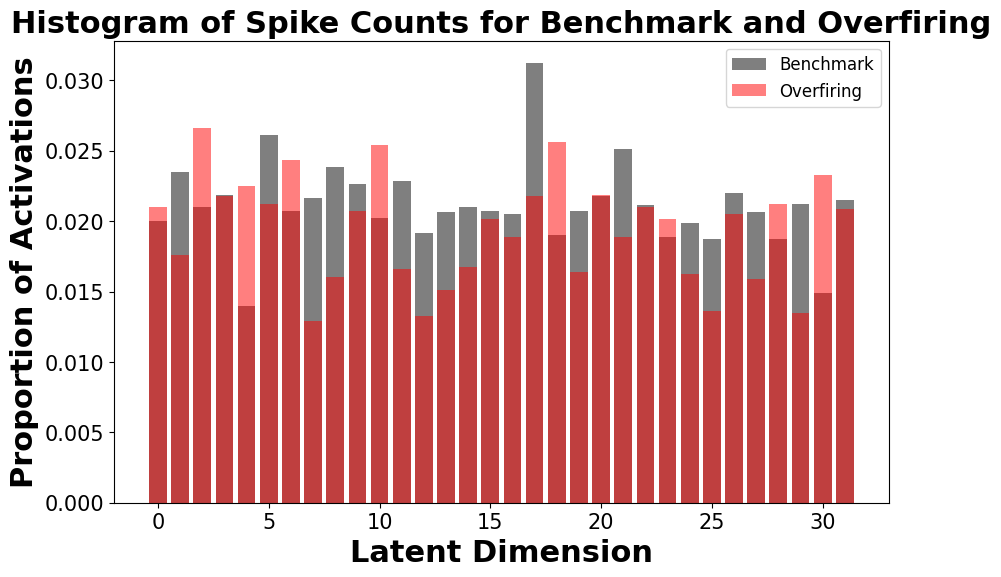

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2, 1, figsize=(16, 10))
font_size = 15
font = {'weight': 'bold', 'size': 22}


# Compute total activations for each latent dimension across all samples
total_activations_benchmark = np.sum(Bnchmrk_Enc_Syn1, axis=0)
total_activations_overfiring = np.sum(Ovrfrng_Enc_Syn1, axis=0)
print('Bnchmrk_Enc_Syn1: ', Bnchmrk_Enc_Syn1.shape)
print('total_activations_benchmark: ', total_activations_benchmark.shape)
print('total_activations_benchmark: ', total_activations_benchmark)
print('------------------\n')
print('Ovrfrng_Enc_Syn1: ', Ovrfrng_Enc_Syn1.shape)
print('total_activations_overfiring: ', total_activations_overfiring.shape)
print('total_activations_overfiring: ', total_activations_overfiring)



# Calculate proportion of activations for each latent dimension
proportion_benchmark = total_activations_benchmark / (Bnchmrk_Enc_Syn1.shape[0] * Bnchmrk_Enc_Syn1.shape[1])
proportion_overfiring = total_activations_overfiring / (Ovrfrng_Enc_Syn1.shape[0] * Ovrfrng_Enc_Syn1.shape[1])

# Create bins representing each latent dimension
latent_dimensions = np.arange(Bnchmrk_Enc_Syn1.shape[1])

# Plot histogram for benchmark data
plt.figure(figsize=(10, 6))
plt.bar(latent_dimensions, proportion_benchmark, color='black', alpha=0.5, label='Benchmark')

# Plot histogram for overfiring data
plt.bar(latent_dimensions, proportion_overfiring, color='red', alpha=0.5, label='Overfiring')

plt.title('Histogram of Spike Counts for Benchmark and Overfiring', fontdict=font)
plt.xlabel('Latent Dimension', fontdict=font)
plt.ylabel('Proportion of Activations', fontdict=font)
plt.legend(fontsize='large')
plt.tick_params(labelsize=font_size)

plt.grid(False)
plt.show()


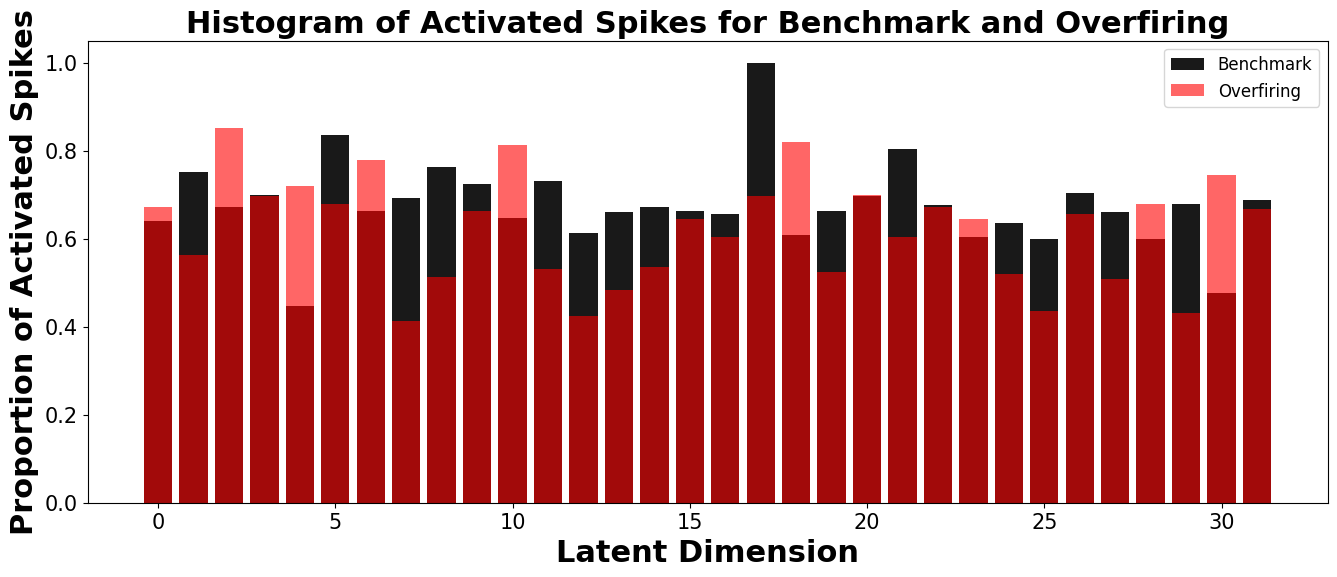

In [34]:
import numpy as np
import matplotlib.pyplot as plt

font_size = 15
font = {'weight': 'bold', 'size': 22}

# Calculate total activations for each latent dimension
total_activations_benchmark = np.sum(Bnchmrk_Enc_Syn1, axis=0)
total_activations_overfiring = np.sum(Ovrfrng_Enc_Syn1, axis=0)

# Calculate total number of samples
total_samples = Bnchmrk_Enc_Syn1.shape[0]

# Calculate proportion of activations for each latent dimension
proportion_benchmark = total_activations_benchmark / total_samples
proportion_overfiring = total_activations_overfiring / total_samples

# Create bins representing each latent dimension
latent_dimensions = np.arange(total_activations_benchmark.shape[0])

# Calculate bin height for each latent dimension
bin_height_benchmark = proportion_benchmark
bin_height_overfiring = proportion_overfiring

# Plot histogram
plt.figure(figsize=(16, 6))
plt.bar(latent_dimensions, bin_height_benchmark, color='black', alpha=0.9, label='Benchmark')
plt.bar(latent_dimensions, bin_height_overfiring, color='red', alpha=0.6, label='Overfiring')

plt.title('Histogram of Activated Spikes for Benchmark and Overfiring', fontdict=font)
plt.xlabel('Latent Dimension', fontdict=font)
plt.ylabel('Proportion of Activated Spikes', fontdict=font)
plt.legend(fontsize='large')
plt.tick_params(labelsize=font_size)
plt.grid(False)
plt.show()


Bnchmrk_Enc_Syn1 [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 ...
 [0. 1. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 0. 0. 0.]]
size accumulated_activations_benchmark: (250, 32)
accumulated_activations_benchmark: [[ 0.  1.  1. ... 14. 14. 14.]
 [ 0.  0.  1. ... 15. 16. 16.]
 [ 1.  2.  3. ... 20. 21. 21.]
 ...
 [ 0.  1.  1. ... 17. 18. 19.]
 [ 1.  1.  1. ... 19. 20. 21.]
 [ 1.  2.  2. ... 14. 14. 14.]]
---------------------

Ovrfrng_Enc_Syn1 [[0. 0. 1. ... 0. 1. 1.]
 [1. 0. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 0. 1.]
 ...
 [1. 1. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 0. 1. 1.]]
size accumulated_activations_overfiring: (250, 32)
accumulated_activations_overfiring: [[ 0.  0.  1. ... 11. 12. 13.]
 [ 1.  1.  2. ... 19. 20. 20.]
 [ 0.  1.  2. ... 21. 21. 22.]
 ...
 [ 1.  2.  2. ... 15. 15. 16.]
 [ 1.  1.  2. ... 13. 14. 15.]
 [ 1.  2.  3. ... 15. 16. 17.]]
-------------------------------------------------

total_activations_benchm

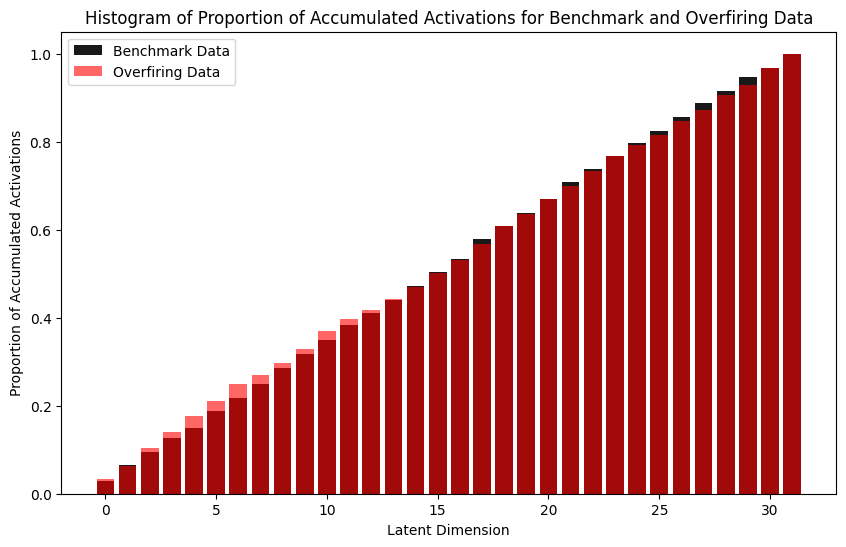

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Accumulate activations for each latent dimension across all samples
accumulated_activations_benchmark = np.cumsum(Bnchmrk_Enc_Syn1, axis=1)
print('Bnchmrk_Enc_Syn1', Bnchmrk_Enc_Syn1)
print('size accumulated_activations_benchmark:', accumulated_activations_benchmark.shape)
print('accumulated_activations_benchmark:', accumulated_activations_benchmark)
print('---------------------\n')

accumulated_activations_overfiring = np.cumsum(Ovrfrng_Enc_Syn1, axis=1)
print('Ovrfrng_Enc_Syn1', Ovrfrng_Enc_Syn1)
print('size accumulated_activations_overfiring:', accumulated_activations_overfiring.shape)
print('accumulated_activations_overfiring:', accumulated_activations_overfiring)

print('-------------------------------------------------\n')

# Total number of samples
total_samples = Bnchmrk_Enc_Syn1.shape[0]

# Calculate the total number of activations for each latent dimension
total_activations_benchmark = np.sum(accumulated_activations_benchmark[:, -1])
print ('total_activations_benchmark', total_activations_benchmark)
print('---------------------\n')

total_activations_overfiring = np.sum(accumulated_activations_overfiring[:, -1])
print ('total_activations_overfiring', total_activations_overfiring)

# Normalize by total number of activations
proportion_benchmark = np.sum(accumulated_activations_benchmark, axis=0) / total_activations_benchmark
proportion_overfiring = np.sum(accumulated_activations_overfiring, axis=0) / total_activations_overfiring

# Create bins representing each latent dimension
latent_dimensions = np.arange(Bnchmrk_Enc_Syn1.shape[1])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(latent_dimensions, proportion_benchmark, color='black', alpha=0.9, label='Benchmark Data')
plt.bar(latent_dimensions, proportion_overfiring, color='red', alpha=0.6, label='Overfiring Data')

plt.title('Histogram of Proportion of Accumulated Activations for Benchmark and Overfiring Data')
plt.xlabel('Latent Dimension')
plt.ylabel('Proportion of Accumulated Activations')
plt.legend()
plt.grid(False)
plt.show()


length of Bnchmrk_Enc_Syn1: 250
spike_counts_benchmark [14. 16. 21. 25. 19. 25. 26. 19. 24. 27. 18. 21. 19. 23. 21. 24. 23. 24.
 21. 23. 22. 22. 18. 21. 24. 27. 24. 24. 20. 25. 24. 25. 22. 27. 20. 27.
 17. 26. 20. 26. 21. 22. 26. 25. 17. 26. 22. 18. 19. 24. 23. 23. 24. 26.
 23. 22. 27. 22. 24. 19. 28. 20. 19. 23. 23. 20. 20. 23. 22. 17. 22. 23.
 22. 22. 20. 24. 23. 26. 23. 21. 25. 25. 22. 22. 24. 22. 20. 21. 19. 25.
 26. 26. 17. 21. 20. 24. 22. 21. 21. 21. 22. 22. 21. 26. 20. 26. 22. 23.
 26. 17. 26. 19. 23. 22. 18. 21. 18. 28. 21. 21. 18. 18. 24. 22. 19. 21.
 20. 21. 14. 20. 22. 18. 26. 23. 21. 24. 21. 22. 21. 17. 21. 21. 17. 21.
 19. 22. 21. 22. 25. 25. 22. 21. 22. 21. 24. 21. 20. 18. 18. 23. 17. 26.
 22. 23. 22. 28. 23. 18. 18. 21. 24. 20. 22. 21. 19. 15. 23. 14. 26. 22.
 26. 23. 21. 27. 24. 19. 27. 23. 20. 23. 20. 29. 20. 20. 20. 18. 20. 21.
 26. 22. 20. 24. 12. 24. 20. 20. 22. 18. 23. 23. 23. 19. 29. 21. 22. 22.
 23. 19. 22. 23. 22. 22. 15. 14. 15. 18. 15. 21. 17. 17. 15. 15. 22. 

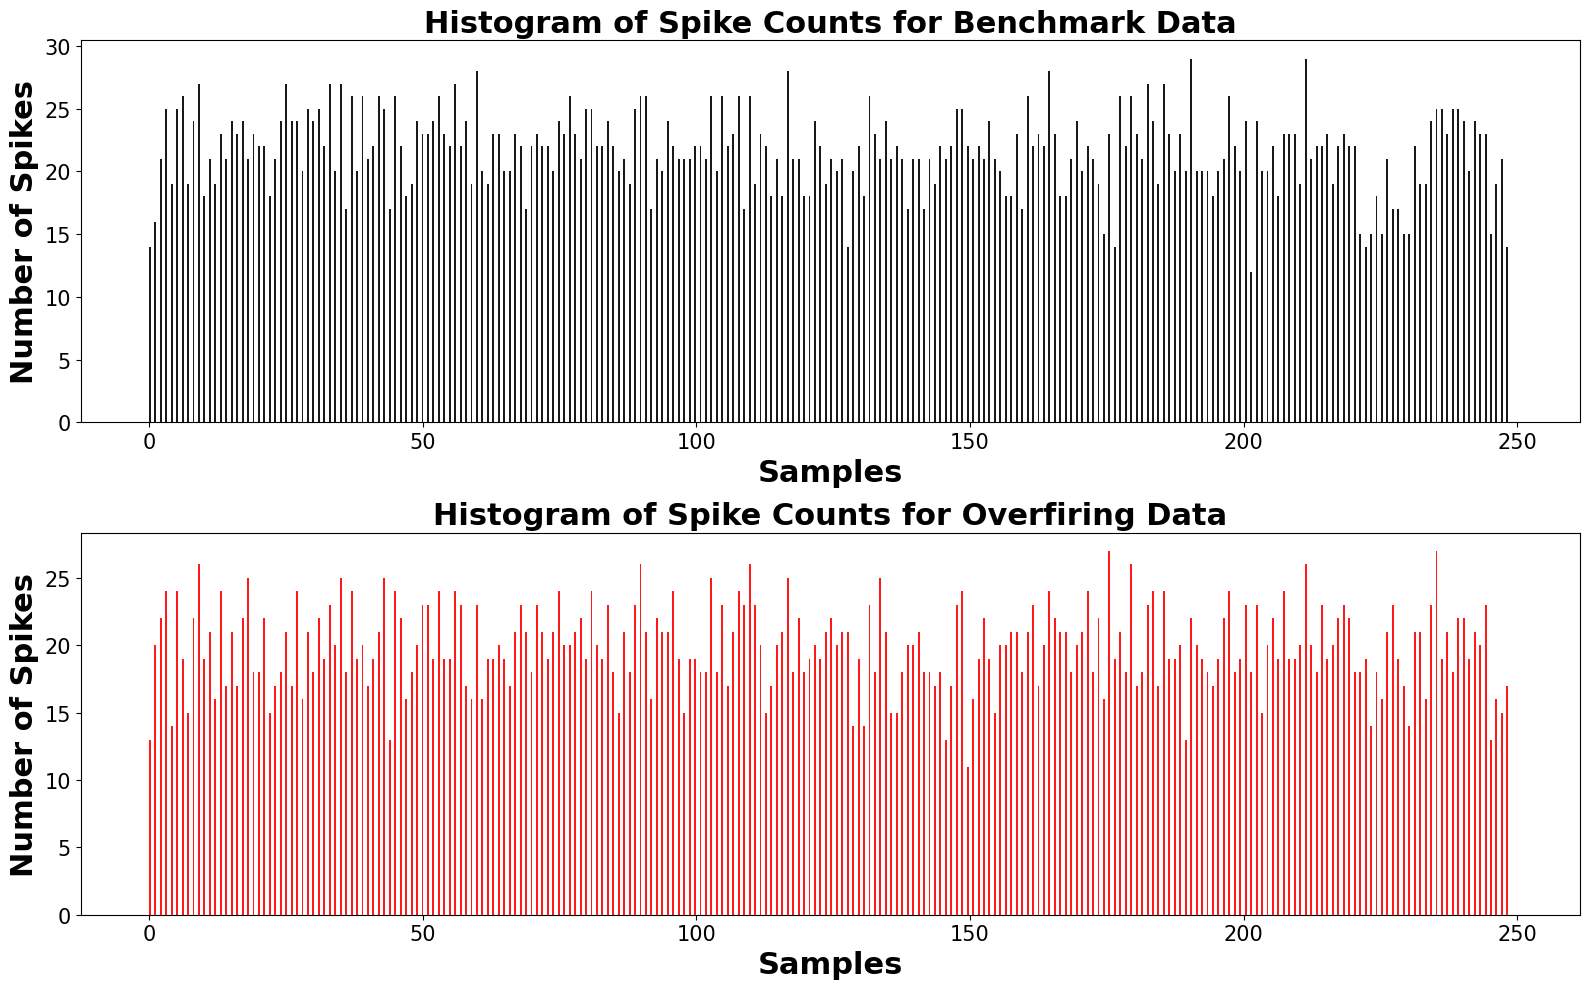

In [18]:
spike_counts_benchmark = np.sum(Bnchmrk_Enc_Syn1[:], axis=1)
print('length of Bnchmrk_Enc_Syn1:' , len(Bnchmrk_Enc_Syn1[:]))
print ('spike_counts_benchmark', spike_counts_benchmark)
spike_counts_Overfiring = np.sum(Ovrfrng_Enc_Syn1[:], axis=1)
print('--------------------------------------')
print('spike_counts_Overfiring', spike_counts_Overfiring)


fig, axs = plt.subplots(2, 1, figsize=(16, 10))
font_size = 15
font = {'weight': 'bold', 'size': 22}


# Plotting histogram for benchmark data
axs[0].hist(range(len(spike_counts_benchmark)), bins=len(spike_counts_benchmark), weights=spike_counts_benchmark, color='black', alpha=0.9, width=0.35)
axs[0].set_title('Histogram of Spike Counts for Benchmark', fontdict=font)
axs[0].set_xlabel('Samples', fontweight="bold", fontdict=font)
axs[0].set_ylabel('Number of Spikes', fontweight="bold", fontdict=font)
axs[0].tick_params(labelsize=font_size)
axs[0].grid(False)

# Plotting histogram for Overfiring data
axs[1].hist(range(len(spike_counts_Overfiring)), bins=len(spike_counts_Overfiring), weights=spike_counts_Overfiring, color='red', alpha=0.9, width=0.35)
axs[1].set_title('Histogram of Spike Counts for Overfiring', fontdict=font)
axs[1].set_xlabel('Samples', fontweight="bold", fontdict=font)
axs[1].set_ylabel('Number of Spikes', fontweight="bold", fontdict=font)
axs[1].tick_params(labelsize=font_size)
axs[1].grid(False)

plt.tight_layout()
plt.show()


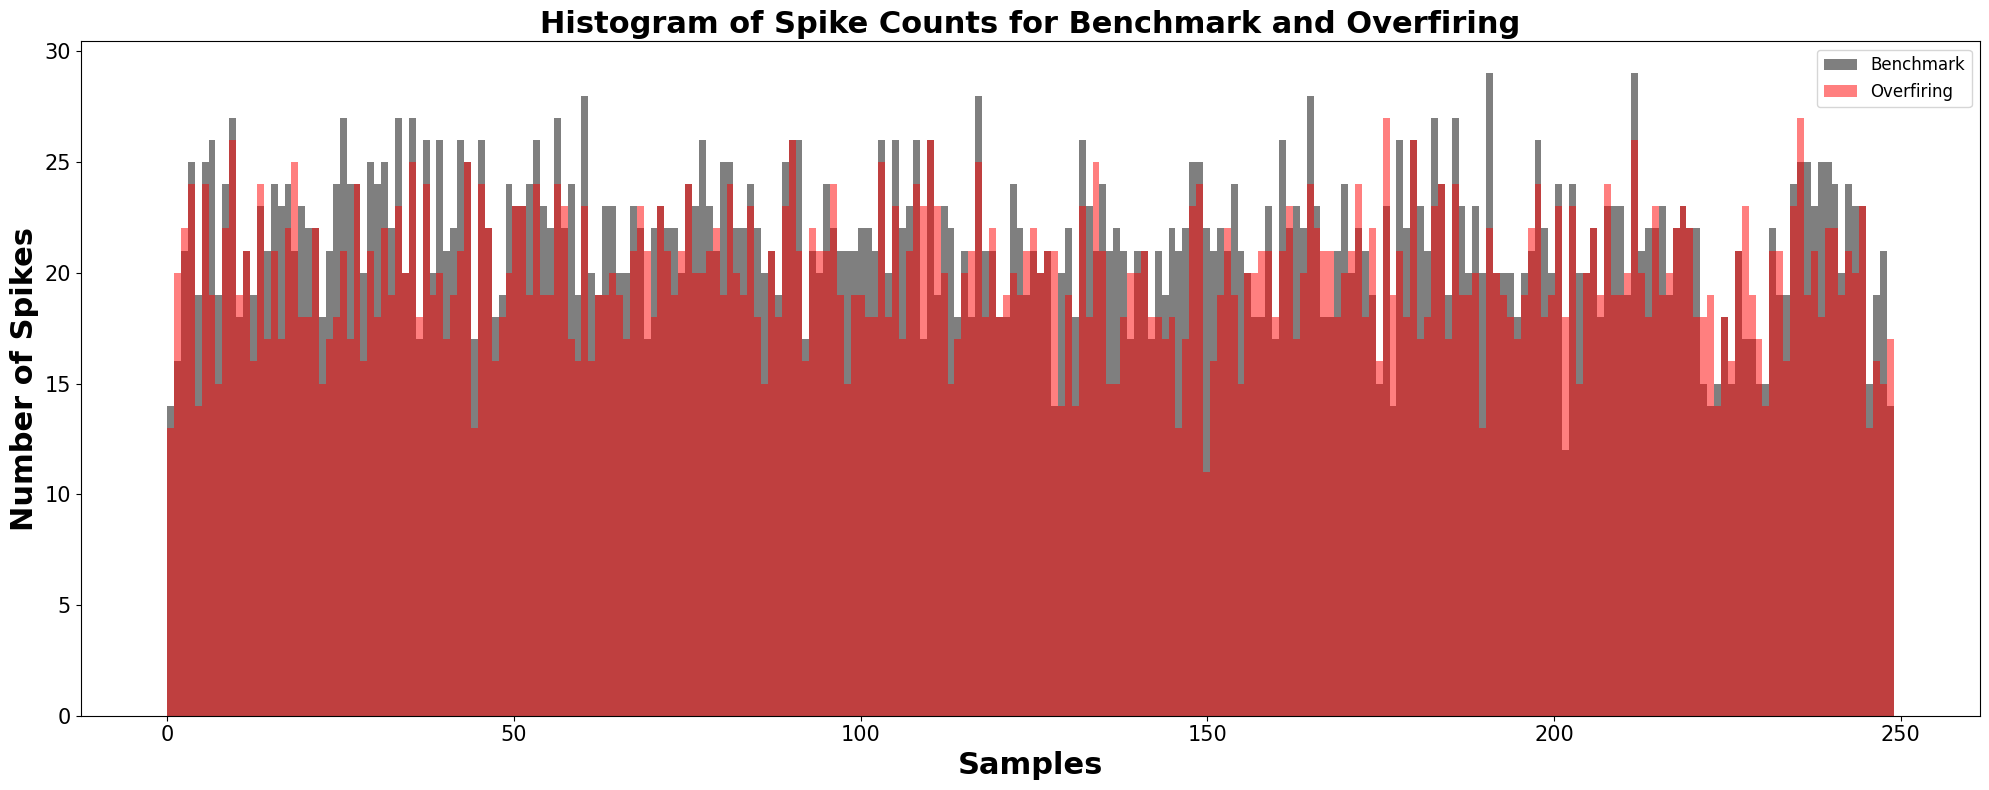

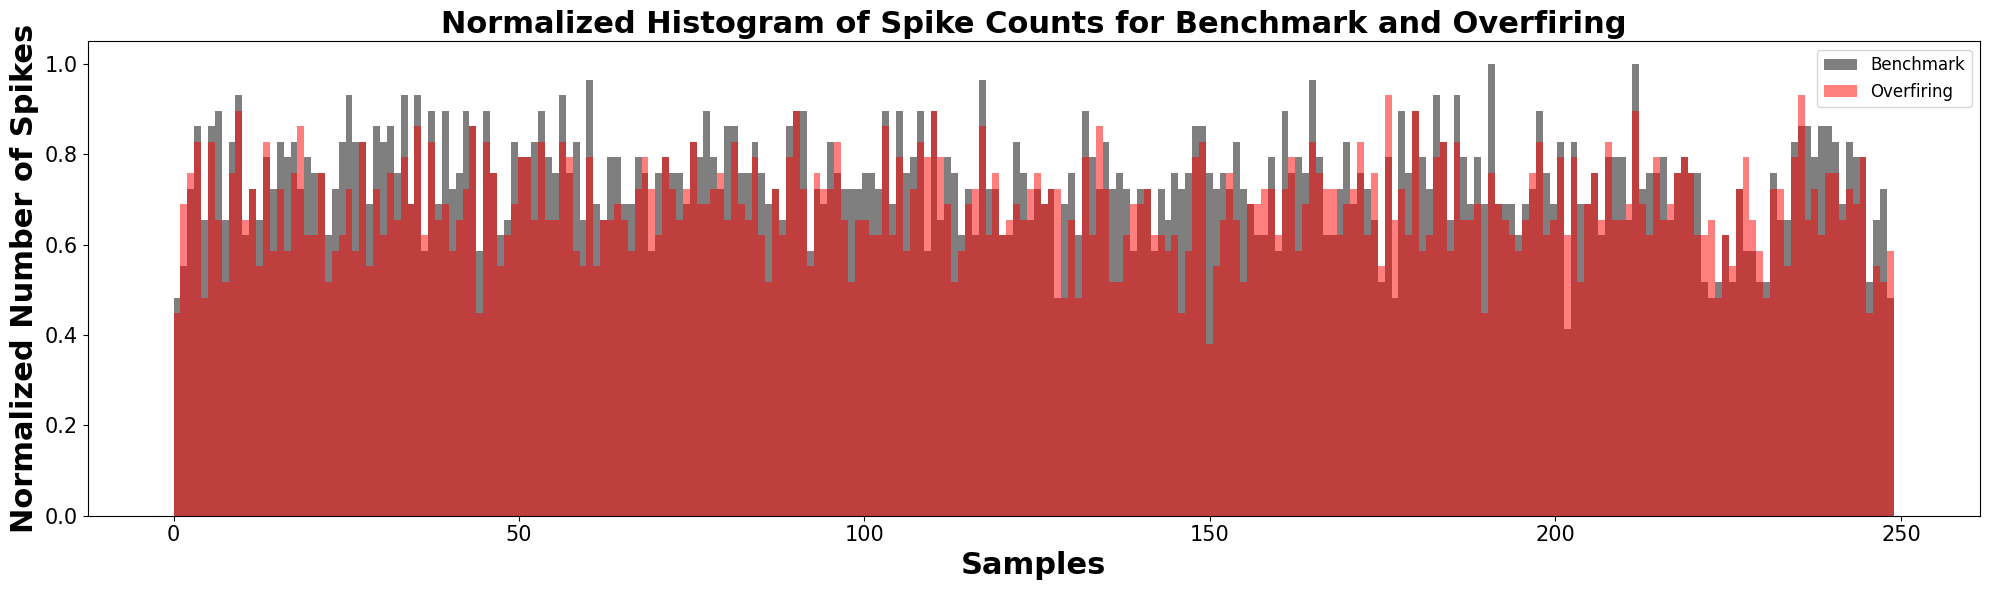

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming spike_counts_benchmark and spike_counts_Overfiring are already defined

# Calculate spike counts for benchmark and Overfiring
spike_counts_benchmark = np.sum(Bnchmrk_Enc_Syn1[:], axis=1)
spike_counts_Overfiring = np.sum(Ovrfrng_Enc_Syn1[:], axis=1)

# Plotting histogram for benchmark and Overfiring data together
plt.figure(figsize=(20, 8))
font_size = 15
font = {'weight': 'bold', 'size': 22}

# Plot histogram for benchmark data
plt.hist(range(len(spike_counts_benchmark)), bins=len(spike_counts_benchmark), weights=spike_counts_benchmark, color='black', alpha=0.5, label='Benchmark')

# Plot histogram for Overfiring data
plt.hist(range(len(spike_counts_Overfiring)), bins=len(spike_counts_Overfiring), weights=spike_counts_Overfiring, color='red', alpha=0.5, label='Overfiring')

plt.title('Histogram of Spike Counts for Benchmark and Overfiring', fontdict=font)
plt.xlabel('Samples', fontweight="bold", fontdict=font)
plt.ylabel('Number of Spikes', fontweight="bold", fontdict=font)
plt.tick_params(labelsize=font_size)
plt.legend(fontsize='large')
plt.tight_layout()
plt.show()



import numpy as np
import matplotlib.pyplot as plt

# Assuming spike_counts_benchmark and spike_counts_Overfiring are already defined

# Calculate spike counts for benchmark and Overfiring
spike_counts_benchmark = np.sum(Bnchmrk_Enc_Syn1[:], axis=1)
spike_counts_Overfiring = np.sum(Ovrfrng_Enc_Syn1[:], axis=1)

# Normalize spike counts
max_spike_count = max(np.max(spike_counts_benchmark), np.max(spike_counts_Overfiring))
spike_counts_benchmark_normalized = spike_counts_benchmark / max_spike_count
spike_counts_Overfiring_normalized = spike_counts_Overfiring / max_spike_count

# Plotting histogram for benchmark and Overfiring data together
plt.figure(figsize=(20, 6))
font_size = 15
font = {'weight': 'bold', 'size': 22}

# Plot histogram for benchmark data
plt.hist(range(len(spike_counts_benchmark_normalized)), bins=len(spike_counts_benchmark_normalized), weights=spike_counts_benchmark_normalized, color='black', alpha=0.5, label='Benchmark')

# Plot histogram for Overfiring data
plt.hist(range(len(spike_counts_Overfiring_normalized)), bins=len(spike_counts_Overfiring_normalized), weights=spike_counts_Overfiring_normalized, color='red', alpha=0.5, label='Overfiring')

plt.title('Normalized Histogram of Spike Counts for Benchmark and Overfiring', fontdict=font)
plt.xlabel('Samples', fontweight="bold", fontdict=font)
plt.ylabel('Normalized Number of Spikes', fontweight="bold", fontdict=font)
plt.tick_params(labelsize=font_size)
plt.grid(False)

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()


<Figure size 2000x600 with 0 Axes>

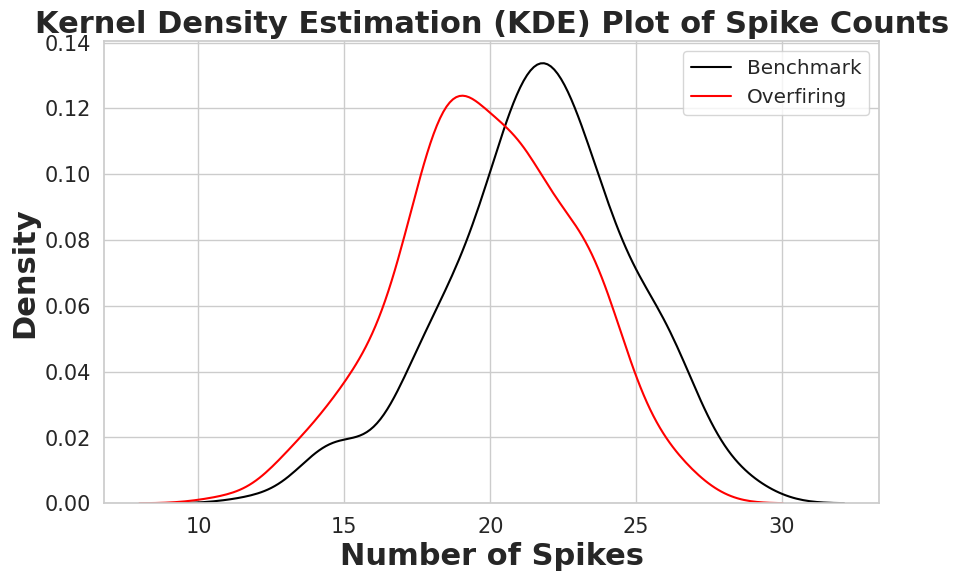

Benchmark Data Statistics:
Mean: 21.63
Median: 21.63
Standard Deviation: 3.14
Skewness: -0.31

Overfiring Data Statistics:
Mean: 19.89
Median: 19.89
Standard Deviation: 3.04
Skewness: -0.13


<Figure size 2000x600 with 0 Axes>

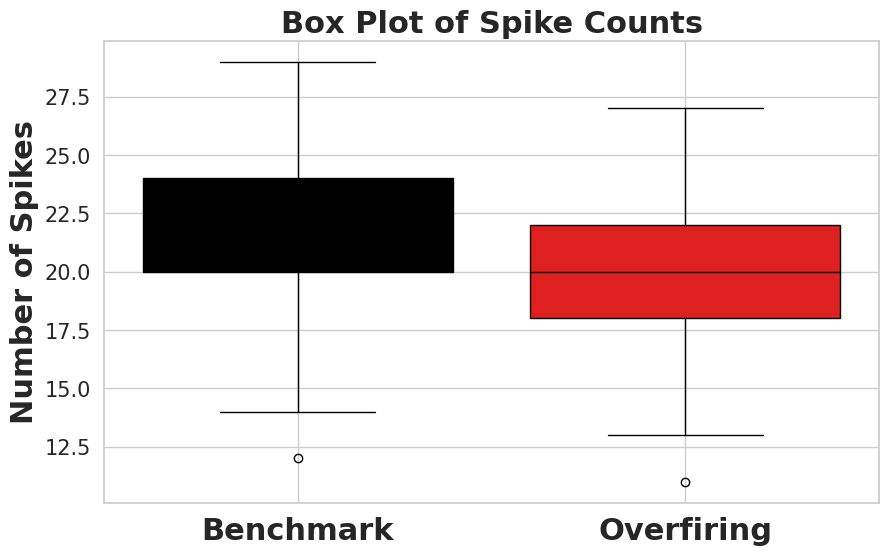

Benchmark Data Statistics:
Mean: 21.63
Median: 21.63
Standard Deviation: 3.14
Skewness: -0.31

Overfiring Data Statistics:
Mean: 19.89
Median: 19.89
Standard Deviation: 3.04
Skewness: -0.13


In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import describe

plt.figure(figsize=(20, 6))
font_size = 15
font = {'weight': 'bold', 'size': 22}


# Calculate statistics for benchmark data
benchmark_stats = describe(spike_counts_benchmark)

# Calculate statistics for Overfiring data
Overfiring_stats = describe(spike_counts_Overfiring)

# Plot KDE plots for both datasets
plt.figure(figsize=(10, 6))
sns.kdeplot(spike_counts_benchmark, color='black', label='Benchmark')
sns.kdeplot(spike_counts_Overfiring, color='red', label='Overfiring')

plt.title('Kernel Density Estimation (KDE) Plot of Spike Counts', fontdict=font)
plt.xlabel('Number of Spikes', fontdict=font)
plt.ylabel('Density', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.legend(fontsize='large')
plt.grid(True)
plt.show()

# Print statistics for benchmark data
print("Benchmark Data Statistics:")
print(f"Mean: {benchmark_stats.mean:.2f}")
print(f"Median: {benchmark_stats.mean:.2f}")
print(f"Standard Deviation: {np.sqrt(benchmark_stats.variance):.2f}")
print(f"Skewness: {benchmark_stats.skewness:.2f}")
print()

# Print statistics for Overfiring data
print("Overfiring Data Statistics:")
print(f"Mean: {Overfiring_stats.mean:.2f}")
print(f"Median: {Overfiring_stats.mean:.2f}")
print(f"Standard Deviation: {np.sqrt(Overfiring_stats.variance):.2f}")
print(f"Skewness: {Overfiring_stats.skewness:.2f}")



import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import describe

plt.figure(figsize=(20, 6))
font_size = 15
font = {'weight': 'bold', 'size': 22}

# Plot box plots for both datasets
plt.figure(figsize=(10, 6))
sns.boxplot(data=[spike_counts_benchmark, spike_counts_Overfiring], palette=['black', 'red'])
plt.title('Box Plot of Spike Counts', fontdict=font)
# plt.xlabel('', fontdict=font)
plt.ylabel('Number of Spikes', fontdict=font)
plt.tick_params(labelsize=font_size)
plt.xticks([0, 1], ['Benchmark', 'Overfiring'], fontdict=font)
plt.grid(True)
plt.show()

# Print statistics for benchmark data
benchmark_stats = describe(spike_counts_benchmark)
print("Benchmark Data Statistics:")
print(f"Mean: {benchmark_stats.mean:.2f}")
print(f"Median: {benchmark_stats.mean:.2f}")
print(f"Standard Deviation: {np.sqrt(benchmark_stats.variance):.2f}")
print(f"Skewness: {benchmark_stats.skewness:.2f}")
print()

# Print statistics for Overfiring data
Overfiring_stats = describe(spike_counts_Overfiring)
print("Overfiring Data Statistics:")
print(f"Mean: {Overfiring_stats.mean:.2f}")
print(f"Median: {Overfiring_stats.mean:.2f}")
print(f"Standard Deviation: {np.sqrt(Overfiring_stats.variance):.2f}")
print(f"Skewness: {Overfiring_stats.skewness:.2f}")


# Decoder Output

shape of Bnchmrk_Enc_Syn1 torch.Size([250, 1, 32, 32])
shape of Ovrfrng_Enc_Syn1 torch.Size([250, 1, 32, 32])
shape of Ovrfrng_Enc_Syn1_flat torch.Size([250, 1024])


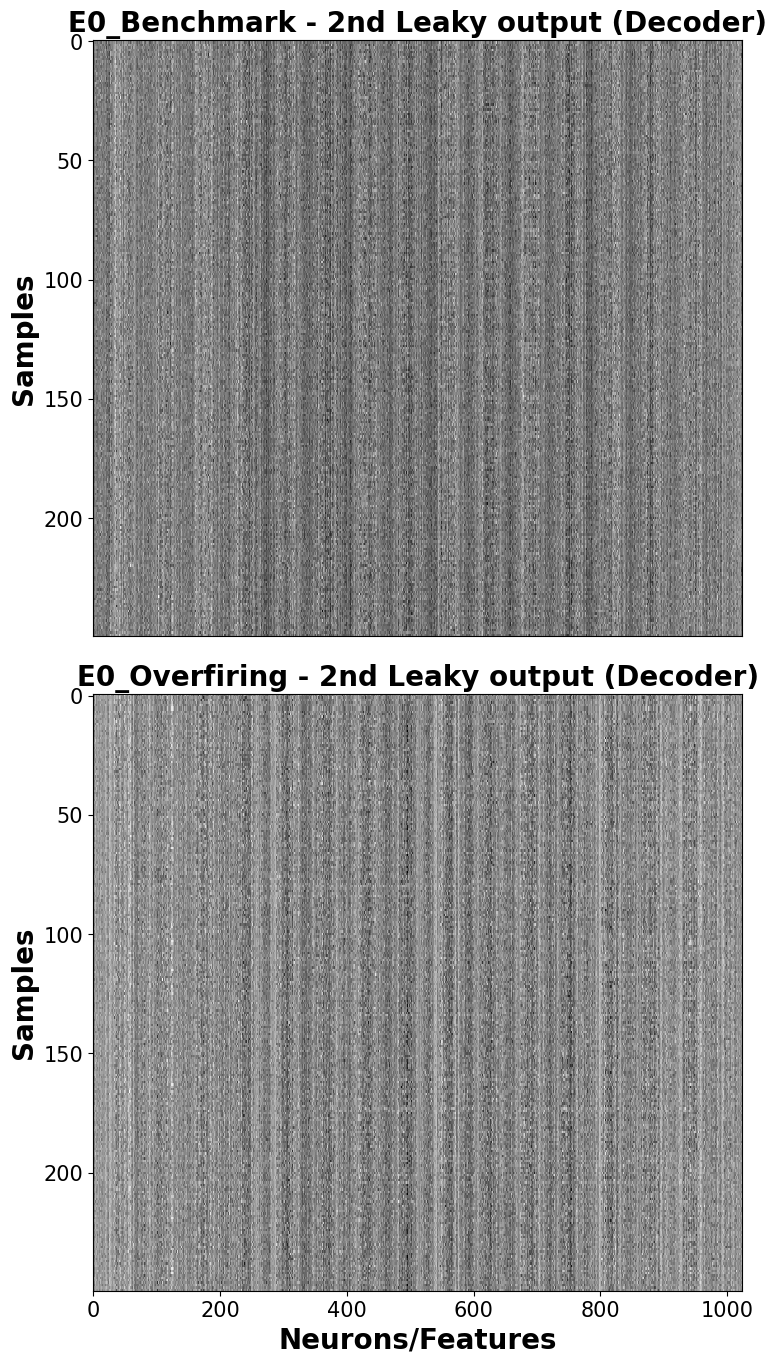

In [ ]:
# hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]

# ----------------loading data to two files:
Bnchmrk_Enc_Syn1= epoch_activations[0]['Dec_Lk2'][1]
Ovrfrng_Enc_Syn1= epoch_activations_OverFiring[0]['Dec_Lk2'][1]
print("shape of Bnchmrk_Enc_Syn1", Bnchmrk_Enc_Syn1.shape)
print("shape of Ovrfrng_Enc_Syn1", Ovrfrng_Enc_Syn1.shape)

# -----------------------
font_size = 15
font = {'weight': 'bold', 'size': 20}


# Flatten the tensors to have shape (num_samples, num_neurons)
Bnchmrk_Enc_Syn1_flat = Bnchmrk_Enc_Syn1.view(Bnchmrk_Enc_Syn1.shape[0], -1)
Ovrfrng_Enc_Syn1_flat = Ovrfrng_Enc_Syn1.view(Ovrfrng_Enc_Syn1.shape[0], -1)
print("shape of Ovrfrng_Enc_Syn1_flat", Ovrfrng_Enc_Syn1_flat.shape)


# Create a binary raster plot
# plt.figure(figsize=(12, 6))
plt.figure(figsize=(8, 14))
plt.subplot(2, 1, 1)
# x_indices = np.tile(np.arange(Bnchmrk_Enc_Syn1_flat.shape[1]), (Bnchmrk_Enc_Syn1_flat.shape[0], 1))
# y_indices = np.arange(Bnchmrk_Enc_Syn1_flat.shape[0]).repeat(Bnchmrk_Enc_Syn1_flat.shape[1])
# plt.scatter(x_indices.flatten(), y_indices, c=Bnchmrk_Enc_Syn1_flat.cpu().flatten(), cmap='binary', marker='|')
plt.imshow(Bnchmrk_Enc_Syn1_flat.cpu(), cmap='binary', aspect='auto', interpolation='none')
plt.title('E0_Benchmark - 2nd Leaky output (Decoder)', fontweight="bold", fontdict=font)
# plt.xlabel('Neurons/Features', fontweight="bold", fontdict=font)
plt.xticks([])  # Remove x-axis ticks
plt.ylabel('Samples', fontweight="bold", fontdict=font)
plt.tick_params(labelsize=font_size)
# plt.ylim(-1, 1)

plt.subplot(2, 1, 2)
# x_indices = np.tile(np.arange(Ovrfrng_Enc_Syn1_flat.shape[1]), (Ovrfrng_Enc_Syn1_flat.shape[0], 1))
# y_indices = np.arange(Ovrfrng_Enc_Syn1_flat.shape[0]).repeat(Ovrfrng_Enc_Syn1_flat.shape[1])
# plt.scatter(x_indices.flatten(), y_indices, c=Ovrfrng_Enc_Syn1_flat.cpu().flatten(), cmap='binary', marker='|')
plt.imshow(Ovrfrng_Enc_Syn1_flat.cpu(), cmap='binary', aspect='auto', interpolation='none')
plt.title('E0_Overfiring - 2nd Leaky output (Decoder)', fontweight="bold", fontdict=font)
plt.xlabel('Neurons/Features', fontweight="bold", fontdict=font)
plt.ylabel('Samples', fontweight="bold", fontdict=font)
plt.tick_params(labelsize=font_size)
# plt.ylim(-1, 1)

# plt.savefig('Dec_Lky2_(Bnchmrk)vs(Ovrfrng).pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.tight_layout(pad=2.0)  # Increase the padding between subplots

plt.show()

# # Create a binary raster plot using scatter with clear markers
# plt.figure(figsize=(8, 14))
# plt.subplot(2, 1, 1)
# # Create x and y indices for scatter plot
# x_indices = np.tile(np.arange(Bnchmrk_Enc_Syn1_flat.shape[1]), (Bnchmrk_Enc_Syn1_flat.shape[0], 1))
# y_indices = np.arange(Bnchmrk_Enc_Syn1_flat.shape[0]).repeat(Bnchmrk_Enc_Syn1_flat.shape[1])
# # Set marker size to make markers overlap
# marker_size = 2
# # Use scatter to create the binary raster plot with clear markers
# plt.scatter(x_indices.flatten(), y_indices, s=marker_size, c=Bnchmrk_Enc_Syn1_flat.cpu().flatten(), cmap='binary', marker='|')
# plt.title('Benchmark - 2nd Leaky output (Encoder)', fontweight="bold", fontdict=font)
# plt.xticks([])  # Remove x-axis ticks
# plt.ylabel('Samples', fontweight="bold", fontdict=font)
# plt.tick_params(labelsize=font_size)

# plt.subplot(2, 1, 2)
# # Create x and y indices for scatter plot
# x_indices = np.tile(np.arange(Ovrfrng_Enc_Syn1_flat.shape[1]), (Ovrfrng_Enc_Syn1_flat.shape[0], 1))
# y_indices = np.arange(Ovrfrng_Enc_Syn1_flat.shape[0]).repeat(Ovrfrng_Enc_Syn1_flat.shape[1])
# # Use scatter to create the binary raster plot with clear markers
# plt.scatter(x_indices.flatten(), y_indices, s=marker_size, c=Ovrfrng_Enc_Syn1_flat.cpu().flatten(), cmap='binary', marker='|')
# plt.title('Overfiring - 2nd Leaky output (Encoder)', fontweight="bold", fontdict=font)
# plt.xlabel('Latent Dimension', fontweight="bold", fontdict=font)
# plt.ylabel('Samples', fontweight="bold", fontdict=font)
# plt.tick_params(labelsize=font_size)


# plt.tight_layout(pad=2.0)
# plt.show()
